In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt




import os

In [2]:
ds = pd.read_csv('database.csv')
ds = ds.sort_values('label')
ds.head()

,label,x1,y1,z1,x2,y2,z2,x3,y3,z3,...,z18,x19,y19,z19,x20,y20,z20,x21,y21,z21
0,A,0.413032,0.922601,-8.876323e-07,0.539955,0.827524,-0.081006,0.652623,0.640106,-0.115715,...,-0.041621,0.238462,0.371768,-0.093708,0.279577,0.495599,-0.067726,0.308212,0.542916,-0.032943
19,A,0.425965,0.884045,-1.035879e-06,0.557272,0.788401,-0.077935,0.678750,0.615317,-0.116312,...,-0.052374,0.275770,0.311781,-0.106419,0.310240,0.452464,-0.071796,0.328937,0.506869,-0.029674
18,A,0.428073,0.879679,-1.008048e-06,0.559191,0.783949,-0.076075,0.680214,0.609983,-0.112803,...,-0.051451,0.275908,0.308935,-0.112038,0.311736,0.452690,-0.082032,0.334614,0.514508,-0.041732
17,A,0.422336,0.882382,-9.948675e-07,0.551011,0.786695,-0.075771,0.667690,0.612336,-0.111683,...,-0.050138,0.271349,0.320383,-0.103441,0.306063,0.457641,-0.071088,0.325626,0.513916,-0.030990
16,A,0.412571,0.895976,-9.307126e-07,0.534254,0.802050,-0.074548,0.646986,0.623550,-0.106491,...,-0.045460,0.257467,0.348241,-0.092668,0.292239,0.474418,-0.062387,0.313780,0.523663,-0.025849


In [3]:
num_samples = len(ds)
classes = pd.unique(ds.label)
print(f'Samples: {num_samples}')
print(f'Classes: {classes}')

Samples: 66
Classes: ['A' 'B' 'C' 'D']


In [4]:
# Shuffle and split
ds_y = ds.label.array
ds_y = pd.factorize(ds_y)[0]
ds_y = np.array(ds_y)

ds_x = ds.drop(['label'], axis=1)
ds_x = ds_x.to_numpy()

In [5]:
print(ds_y.shape)
print(ds_x.shape)

(66,)
(66, 63)


In [6]:
num_samples = ds_x.shape[0]
dim = 3
landmarks = 21
ds_x = ds_x.reshape((num_samples, landmarks, dim))
print(ds_x.shape)

(66, 21, 3)


In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(ds_x, ds_y, test_size=0.2, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(52, 21, 3)
(52,)
(14, 21, 3)
(14,)


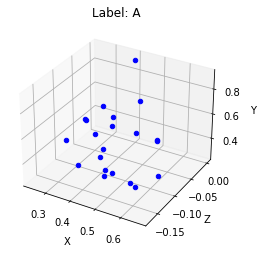

In [8]:
# plot coordinates
num = 10
example = ds_x[num]
label = ds_y[num]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for vec in example:
    ax.scatter(vec[0], vec[2], vec[1], color='b')

plt.title(f'Label: {classes[label]}')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')

plt.show()

In [9]:
# Neural Network

In [10]:
# hyperparameters
epochs = 10
val_split = .2

# labels to one hot
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train.astype(int))
y_test = to_categorical(y_test.astype(int))

print(y_train.shape)
print(y_test.shape)

# create callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_acc',
                           restore_best_weights=True,
                           patience=10,
                           verbose=0)

reduce_lr = ReduceLROnPlateau(monitor='val_acc',
                              factor=0.2,
                              min_lr=0.00001,
                              patience=5,
                              verbose=0)


(52, 4)
(14, 4)


In [11]:
# Model

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, AlphaDropout, LayerNormalization

inputs = Input(shape=x_train[0].shape, name='Landmark_Vectors')

layerNorm = LayerNormalization(name='LayerNorm')(inputs)

flatten = Flatten(name='Flatten_Vectors')(layerNorm)

dense_count = 6
dense_base = 48
out = flatten

for i in range(dense_count):
    units = (dense_count-i) * (dense_count-i) * dense_base
    dense = Dense(units, 
                kernel_initializer="lecun_normal", 
                bias_initializer="zeros", 
                activation='selu',
                name=f'Dense_{i+1}')
    a_dropout = AlphaDropout(0.05, name=f'Dropout_{i+1}')
    out = dense(out)
    out = a_dropout(out)

outputs = Dense(y_train[0].shape[0], activation='softmax', name='Output_Vector')(out)
model = Model(inputs=inputs, outputs=outputs, name="NeuralNetwork")
model.summary()

Model: "SNN_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Landmark_Vectors (InputLayer [(None, 21, 3)]           0         
_________________________________________________________________
LayerNorm (LayerNormalizatio (None, 21, 3)             6         
_________________________________________________________________
Flatten_Vectors (Flatten)    (None, 63)                0         
_________________________________________________________________
Dense_1 (Dense)              (None, 1728)              110592    
_________________________________________________________________
Dropout_1 (AlphaDropout)     (None, 1728)              0         
_________________________________________________________________
Dense_2 (Dense)              (None, 1200)              2074800   
_________________________________________________________________
Dropout_2 (AlphaDropout)     (None, 1200)              0     

In [12]:
# from tensorflow.keras.optimizers import Adam

# adam = Adam(learning_rate=0.001, beta_2=0.99, epsilon=0.01)

# model.compile(loss='categorical_crossentropy',
#               optimizer=adam,
#               metrics=['acc'])

# history = model.fit(x_train, y_train,
#                       epochs=100,
#                       batch_size=32,
#                       validation_split=val_split,
#                       callbacks=[early_stop, reduce_lr],
#                       verbose=0)

In [13]:
from tensorflow.keras.optimizers import Adam

adam = Adam(learning_rate=0.001, beta_2=0.99, epsilon=0.01)
print("adam compiled")
model.compile(loss='categorical_crossentropy',
            optimizer=adam,
            metrics=['acc'])
print("model compiled")
print("model fitting")
# history = 
model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=val_split,
                    callbacks=[early_stop, reduce_lr],
                    verbose=0)

adam compiled
model complete


NameError: name 'history' is not defined

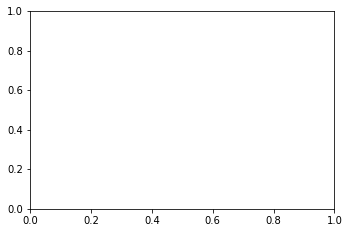

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()

In [ ]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f'++++++++++++ Test data ++++++++++++\nloss={loss:.4f} acc={acc:.4f}')

NameError: name 'model' is not defined

In [ ]:
from sklearn import metrics
import seaborn as sns

predictions = model.predict(x_test)
prediction_classes = np.argmax(predictions, axis=-1)

gt_classes = np.argmax(y_test, axis=-1)
confusion_matrix = metrics.confusion_matrix(gt_classes, prediction_classes)

sns.heatmap(pd.DataFrame(confusion_matrix, index=classes, columns=classes), annot=True, cmap="YlGnBu", fmt='d')
plt.tight_layout()
plt.title('confusion matrix - ' + model.name, y=1.1)
plt.ylabel('predicted')
plt.xlabel('ground truth')
plt.show()


NameError: name 'model' is not defined